# Trackers for currency pairs: momentum, value and carry

## ....

In [7]:
import os
import datetime
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
import statsmodels.api as sm
from scipy.stats import norm
%matplotlib inline

In [8]:
from bloomberg import BBG
bbg = BBG()

#### FX pairs

In [9]:
#long ccy1, Short ccy2
data = [['GBP', 'JPY'], ['BRL', 'MXN'], ['AUD', 'NZD'], ['SEK', 'NOK'], ['CHF', 'EUR']] 
pair_ccy = pd.DataFrame(data, columns = ['ccy1', 'ccy2']) 
pair_ccy

,ccy1,ccy2
0,GBP,JPY
1,BRL,MXN
2,AUD,NZD
3,SEK,NOK
4,CHF,EUR


In [10]:
country_dic = {'AUD' : 'AS', 'BRL' : 'BZ', 'CAD' : 'CA', 'CHF' : 'SZ', 'EUR' : 'EUAR', 'GBP' : 'UK', 
               'JPY' : 'JN', 'MXN' : 'MX', 'NOK' : 'NO', 'NZD' : 'NZ', 'SEK' : 'SW',  'USD' : 'US'}

In [11]:
# Period
startdateDB ='2012-01-01'
enddateDB ='2019-12-31'

## MOMENTUM

In [12]:
tickers = [
    'GBPJPY Curncy',        # GBPJPY spot exchange rate
    'BRLMXN Curncy',        # BRLMXN spot exchange rate
    'AUDNZD Curncy',        # AUDNZD spot exchange rate
    'SEKNOK Curncy',        # SEKNOK spot exchange rate
    'CHFEUR Curncy',        # GBPEUR spot exchange rate
]

bbg_data1 = bbg.fetch_series(securities=tickers, fields='PX_LAST', startdate=startdateDB, enddate=enddateDB)
#bbg_data = bbg_data.dropna()
bbg_data1.tail()

,GBPJPY Curncy,BRLMXN Curncy,AUDNZD Curncy,SEKNOK Curncy,CHFEUR Curncy
2019-12-25 00:00:00,141.707,4.657,1.0431,0.943,0.9199
2019-12-26 00:00:00,142.436,4.67,1.0413,0.9435,0.9185
2019-12-27 00:00:00,143.137,4.656,1.0422,0.9452,0.9178
2019-12-30 00:00:00,142.788,4.71,1.0398,0.9433,0.9211
2019-12-31 00:00:00,144.072,4.703,1.0421,0.9375,0.9216


In [13]:
signal_types = ['classic', 'classic_log', 'classic_minus_1', 'macd', 'p_value', 'rsi']

#### Função genérica para diferentes tipos de momentum

In [14]:
def get_lagged_vol(ts, h=21, vol_type='ewma', min_vol_window=756, halflife=60):
    lagged_data = ts.astype(float).shift(1)  # note the day lag!!
    lagged_data.index = pd.DatetimeIndex(pd.to_datetime(lagged_data.index))
    if vol_type == 'ewma': # From Moskowitz, Ooi, and Pedersen (2012) and roughly similar to a GARCH(1, 1) model        
        vols = np.sqrt(((np.log(lagged_data).diff(1)**2).ewm(halflife=halflife).mean())*252)
    else:
        if vol_type != 'rolling':
            print('vol_type not recognized, assuming rolling window of %s bdays over %s bday returns' % (min_vol_window,h))
        vols = np.log(lagged_data).diff(h).rolling(window=min_vol_window).std()*np.sqrt(252/h)
    return vols

In [15]:
def momentum(ts, h=252, signal_type='classic', vol_adjust=False):
    
    df = ts.astype(float).shift(1) 
    df.index = pd.to_datetime(df.index)
    
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)        
        
    elif signal_type=='classic_minus_1':        
        df_mom = np.log(df).diff(h).shift(21)
        
    elif signal_type=='macd':
        df_rap = df.ewm(halflife=12).mean()
        df_len = df.ewm(halflife=26).mean()
        df_mom = df_rap - df_len     
        
    elif signal_type=='p_value':
        rets = np.log(df).diff(h)
        vols = get_lagged_vol(ts)                            
        ttest = (((rets/h) * np.sqrt(252))/vols).dropna()
        df_mom = pd.Series(index=ttest.index,data=(2*norm.cdf(ttest)- 1))  # this normalizes the signal to be in between [-1,1]
        
    elif signal_type=='rsi':
        df_delta = df.diff().dropna()    
        up, down = df_delta.copy(), df_delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        roll_up1 = up.rolling(h).sum()
        roll_down1 = down.rolling(h).sum().abs()
        df_rs = roll_up1 / roll_down1
        df_mom = 100 - 100 / (1 + df_rs)        
        
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    
    if vol_adjust: 
        if isinstance(vol_adjust,bool):
            vols = get_lagged_vol(ts)                            
        else:
            vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
        return df_mom/vols
    else:                
        return df_mom

In [16]:
#As default signal_type='classic'and h = 252
pairs_mom = pd.DataFrame()
pairs_mom['GBPJPY'] = momentum(bbg_data1['GBPJPY Curncy'] , vol_adjust = True)
pairs_mom['BRLMXN'] = momentum(bbg_data1['BRLMXN Curncy'] , vol_adjust = True)
pairs_mom['AUDNZD'] = momentum(bbg_data1['AUDNZD Curncy'] , vol_adjust = True)
pairs_mom['SEKNOK'] = momentum(bbg_data1['SEKNOK Curncy'] , vol_adjust = True)
pairs_mom['CHFEUR'] = momentum(bbg_data1['CHFEUR Curncy'] , vol_adjust = True)

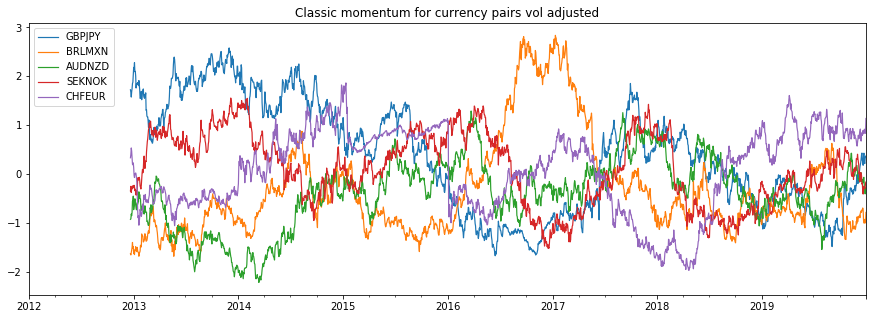

In [17]:
pairs_mom.plot(title='Classic momentum for currency pairs vol adjusted',figsize=(15,5),linewidth=1.2)
plt.show()

## VALUE

#### RER

$$
RER_{ccy1ccy2} = Spot_{ccy1ccy2} \times \frac{P_{ccy1}}{P_{ccy2}}
$$

#### PPP value


$$
Value_{ccy1ccy2} = \ln(RER_{ccy1ccy2})
$$


In [18]:
#Define value signals as lists
value = []
zero_mean = []
zscore = []

#For each currency pair we find out the three types of value
for i,pair in pair_ccy.iterrows():
    inverse_quote = bbg.fetch_contract_parameter(securities=pair['ccy1'] + ' Curncy', field='INVERSE_QUOTED')
    ccy1_quote = pair['ccy1'] + 'USD' if inverse_quote.iloc[0,0]=='Y' else 'USD' + pair['ccy1']
    inverse_quote = bbg.fetch_contract_parameter(securities=pair['ccy2'] + ' Curncy', field='INVERSE_QUOTED')
    ccy2_quote = pair['ccy2'] + 'USD' if inverse_quote.iloc[0,0]=='Y' else 'USD' + pair['ccy2']

    spot_rates = bbg.fetch_contract_parameter(securities=[pair['ccy1'] + ' Curncy',pair['ccy2'] + ' Curncy'], field='PX_LAST')
        
    bbg_data2 = bbg.fetch_series(securities=[pair['ccy1']  + ' Curncy',pair['ccy2'] + ' Curncy',
                                            'PPP ' + country_dic[pair['ccy1'] .replace(' Curncy','') ] + ' Index',
                                            'PPP ' + country_dic[pair['ccy2'].replace(' Curncy','') ] + ' Index'],
                                            fields='PX_LAST',startdate=startdateDB, enddate=enddateDB)
    
    #bbg_data2 = bbg_data2.fillna(method='ffill').dropna()
    bbg_data2 = bbg_data2.fillna(method='ffill')
    
    if ccy1_quote[:3] == 'USD' and ccy2_quote[:3] != 'USD':
        spot_fx =  (1/bbg_data2[pair['ccy2'] + ' Curncy'])/bbg_data2[pair['ccy1'] + ' Curncy']
    elif ccy1_quote[:3] != 'USD' and ccy2_quote[:3] == 'USD':
        spot_fx =  bbg_data2[pair['ccy2'] + ' Curncy']/(1/bbg_data2[pair['ccy1'] + ' Curncy'])
    else:
        spot_fx =  bbg_data2[pair['ccy1'] + ' Curncy']/bbg_data2[pair['ccy2'] + ' Curncy']

    RER = spot_fx * bbg_data2['PPP ' + country_dic[pair['ccy1'].replace(' Curncy','') ] + ' Index']/bbg_data2['PPP ' + country_dic[pair['ccy2'].replace(' Curncy','') ] + ' Index']
    #value = np.log(RER)
    value.append(np.log(RER))
    #value[i].plot(title='Value for %s' % pair['ccy1'] + pair['ccy2'],figsize=(6,4))
    #plt.show()
    
    zero_mean.append(value[i] - value[i].rolling(window=252).mean())
    #zero_mean[i].plot(title='Value minus the 1Y rolling mean metric for %s' % pair['ccy1']  + pair['ccy2'] ,figsize=(6,4))
    #plt.show()
    
    zscore.append((value[i] - value[i].rolling(window=252).mean())/value[i].rolling(window=252).std())
    #zscore[i].plot(title='Rolling 1Y z-score value metric for %s' % pair['ccy1'] + pair['ccy2'] ,figsize=(6,4))
    #plt.show()


In [19]:
def plotChats_value(value, zero_mean, zscore, pair):

    fig = plt.figure(constrained_layout=True, figsize=(14, 8))
    spec = gridspec.GridSpec(ncols=3, nrows=len(value), figure=fig)

    for i in range(len(value)): 

        ax = fig.add_subplot(spec[i, 0])
        ax.plot(value[i].index, value[i].values, linewidth=0.8)
        ax.set_title("Value for " + pair_ccy.iloc[i,0] + pair_ccy.iloc[i,1] , fontsize = 12)
        ax.xaxis.set_major_formatter(DateFormatter("%Y"))
        ax.xaxis.set_major_locator(MonthLocator(6))

        ax = fig.add_subplot(spec[i, 1])
        ax.plot(zero_mean[i].index, zero_mean[i].values, color = 'blue', linewidth=0.8)
        ax.set_title("Zero mean for " + pair_ccy.iloc[i,0] + pair_ccy.iloc[i,1], fontsize = 12)
        ax.xaxis.set_major_formatter(DateFormatter("%Y"))
        ax.xaxis.set_major_locator(MonthLocator(6))

        ax = fig.add_subplot(spec[i, 2])
        ax.plot(zscore[i].index, zscore[i].values, color = 'green', linewidth=0.8)
        ax.set_title("z scores for " + pair_ccy.iloc[i,0] + pair_ccy.iloc[i,1], fontsize = 12)
        ax.xaxis.set_major_formatter(DateFormatter("%Y"))
        ax.xaxis.set_major_locator(MonthLocator(6))
        
    plt.show()

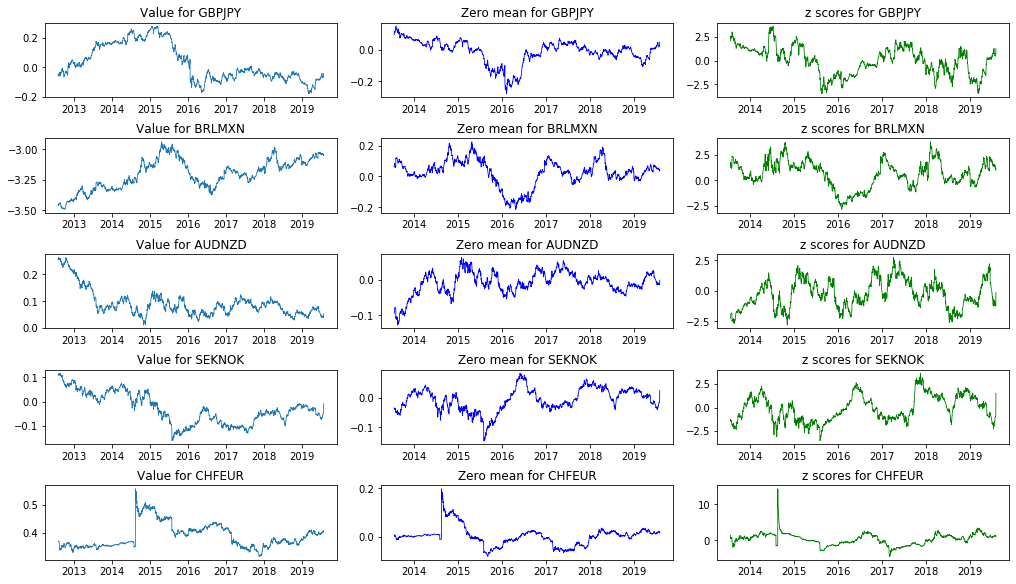

In [20]:
plotChats_value(value, zero_mean, zscore, pair)

## CARRY

In [21]:
tickers_GBPJPY = [
    
    'JYDRC BDSR Curncy',    # JPY 3M deposit rate
    'BPDRC BDSR Curncy',    # GBP 3M deposit rate
    'GBPJPY Curncy',        # GBPJPY spot exchange rate
    'GBPJPYV3M BGN Curncy', # GBPJPY 3M ATM implied volatility
]

bbg_data3 = bbg.fetch_series(securities=tickers_GBPJPY,fields='PX_LAST', startdate=startdateDB, enddate=enddateDB)
#bbg_data = bbg_data.dropna()
#bbg_data3

#### The three types of carry 

In [22]:
bbg_data3['carry'] = (1+bbg_data3['BPDRC BDSR Curncy']/100)/(1+bbg_data3['JYDRC BDSR Curncy']/100)-1
bbg_data3['fwd'] = bbg_data3['GBPJPY Curncy']*((1+bbg_data3['JYDRC BDSR Curncy']/100)/(1+bbg_data3['BPDRC BDSR Curncy']/100))**(12/3)
bbg_data3['fwd_carry'] = (bbg_data3['GBPJPY Curncy']/bbg_data3['fwd'])**(12/3) -1
bbg_data3['vol_adj_carry'] = (bbg_data3['fwd_carry']/bbg_data3['GBPJPYV3M BGN Curncy']/100)
carry_BGPJPY = bbg_data3[['carry','fwd_carry','vol_adj_carry']]
carry_BGPJPY.head()


,carry,fwd_carry,vol_adj_carry
2012-01-02 00:00:00,0.00903464,0.154775,0.000133254
2012-01-03 00:00:00,0.00913447,0.156604,0.000136355
2012-01-04 00:00:00,0.00913447,0.156604,0.00013512
2012-01-05 00:00:00,0.00913447,0.156604,0.000134136
2012-01-06 00:00:00,0.00913447,0.156604,0.000138099


In [25]:
def plotChat_carry(carry_BGPJPY):

    fig = plt.figure(constrained_layout=True, figsize=(15, 3))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

    ts_index = pd.to_datetime(carry_BGPJPY.index)
    
    for i in range(1): #deixar genérico para o caso de mais pares moeda

        ax = fig.add_subplot(spec[i, 0])
        ax.plot(ts_index, carry_BGPJPY['carry'], linewidth=0.8)
        ax.set_title("Carry for GBPJPY", fontsize = 12)
        ax.xaxis.set_major_formatter(DateFormatter("%Y"))
        ax.xaxis.set_major_locator(MonthLocator(6))

        ax = fig.add_subplot(spec[i, 1])
        ax.plot(ts_index, carry_BGPJPY['fwd_carry'], color = 'blue', linewidth=0.8)
        ax.set_title("Forward carry for GBPJPY", fontsize = 12)
        ax.xaxis.set_major_formatter(DateFormatter("%Y"))
        ax.xaxis.set_major_locator(MonthLocator(6))

        ax = fig.add_subplot(spec[i, 2])
        ax.plot(ts_index, carry_BGPJPY['vol_adj_carry'], color = 'green', linewidth=0.8)
        ax.set_title("Volatility adjusted carry for GBPJPY" , fontsize = 12)
        ax.xaxis.set_major_formatter(DateFormatter("%Y"))
        ax.xaxis.set_major_locator(MonthLocator(6))
        
    plt.show()

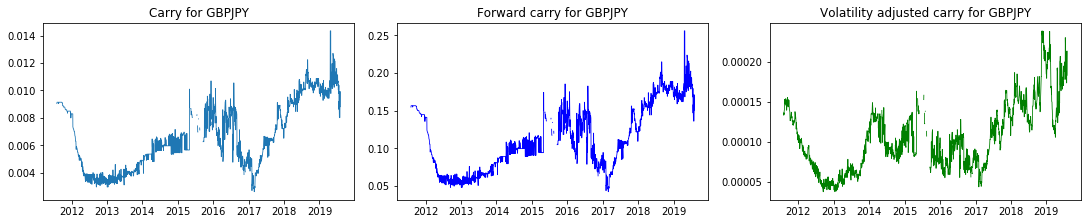

In [26]:
plotChat_carry(carry_BGPJPY)